# Home Assignment

In this assignment, you will leverage our quantum control library ([qililab](https://github.com/qilimanjaro-tech/qililab)) to define pulse sequences for computing the thermal/residual excited-state population of a transmon qubit. The assignment content is derived from the paper: [[1] Thermal and Residual Excited-State Population in a 3D Transmon Qubit](https://arxiv.org/pdf/1412.2772.pdf).


> Please take a look at the Supplementary Material section to understand how to define quantum programs using `qililab`.

## Task 1: Defining a sequence with qililab

For this task we will use `qililab`'s `QProgram` class to define a quantum program that runs the measurement protocol defined in the paper, which involves measuring the e-f Rabi oscillation under two different conditions (see Figure 1 in the paper):

1. A $\pi^{g-e}$ pulse is applied to the qubit, which swaps the populations of states $\ket{g}$ and $\ket{e}$. Then, a varying amplitude $\theta(A)^{e-f}$ driving pulse is applied, and the state $\ket{e}$ is read out as a function of the  $\theta(A)^{e-f}$ pulse amplitude. This allows us to measure the oscillation between the excited state $\ket{e}$ and $\ket{f}$ of the population that was initially in the $\ket{g}$ state.
2. The same process is repeated without playing the first $\pi^{g-e}$ pulse. This allows us to measure the oscillation between the excited state $\ket{e}$ and $\ket{f}$ caused by the thermal population present in $\ket{e}$.

Please write a Python script defining a `QProgram` that runs the 2 sequences mentioned above, with the following assumptions:

- A  $\pi$ pulse consists of a gaussian with 4 sigmas. Please refer to the mentioned paper to get the extra parameters of the pulses. In `qililab`, a gaussian can be defined like: `ql.Gaussian(amplitude=1, duration=200, num_sigmas=4)`
- A readout pulse consists of a square pulse of amplitude 1 and duration 2000ns. In `qililab`, a square pulse can be defined like: `ql.Square(amplitude=1, duration=2000)`.

> Please use comments to explain your code and any assumptions you make.

In [125]:
import qililab as ql
import numpy as np

# from qililab.qprogram import QbloxCompiler, QProgram
# from qililab.qprogram import QbloxCompiler
# from qililab.qprogram.blocks import ForLoop

from qililab.qprogram import QProgram
from qililab.waveforms import Gaussian, IQPair, Square

# Create a sequence of pulses to measure the excited-state populations

qp = ql.QProgram()
gaussian = Gaussian(amplitude = 1, duration = 200, num_sigmas = 4)
sq_pulse = Square(amplitude = 1, duration = 2000)
zero_pulse = Square(amplitude = 0, duration = 2000) #not sure if ql.Square is enough alone so I'm following the example in the documentation
amplitude = qp.variable(float)

with qp.loop(variable = amplitude, values = np.arange(0, 1, 0.01)):
    qp.play(bus = "drive", waveform = gaussian)
    qp.sync()
    qp.play(bus = "readout", waveform = IQPair(I = sq_pulse, Q = zero_pulse))
    qp.acquire(bus = "readout")
    

# I believe the above code solves the problem correctly. However while working on it,
# I wanted to try to get some output, in order to test whether everything is correct.
# I couldnt figure out a way to do it, so I instead found the documentation of the library online
# and went through it: https://qaas.readthedocs.io/projects/qililab/en/latest/index.html.
# I read quite a bit but some pages were missing and I had some other issues which I described below.
#
# I tried to get an output from the loop above in order to verify that the code is running properly at each step,
# but I wasnt successful.
#
# Since I didn't find a way to output something I could use to verify my results, I tried programatically 
# listing all properties of
# the objects of the classes to see if I can find a function that returns an output or a property that
# contains an output, but I did not find any. While doing that, I decided to check Qililab's test cases 
# in the test files in your Github repo 
# to see if I can find a way to run the program and get an output. I didn't find anything in the QProgram 
# testcases - different than what is shown in the supplementary materials section, but the QbloxCompiler looked
# interesting. I tried compiling the program with:
#
# compiler = QbloxCompiler()
# output = compiler.compile(qprogram=qp)
#
# but this was throwing errors so I figured that that is not how the QbloxCompiler is supposed to be used.
#
# I also tried using aquire_loop and for_loop instead of qp.loop. qp.for_loop did not solve my problem, so I went
# for qp.acquire_loop, as shown in here: 
# (https://qaas.readthedocs.io/projects/qililab/en/latest/code/api/qililab.QProgram.html#qililab.QProgram.average)
# 
# I tried using that, but running the example from the documentation like so:
#
# import qililab as ql
# qp = ql.QProgram()
# variable = qp.variable(int)
# with qp.acquire_loop(iterations=1000):
#     variable += 1
#
# print('after loop: ', variable)
# 
# Gave the error that 
# 'QProgram' object has no attribute 'acquire_loop'.

## Task 2: Calculating the thermal population and the temperature of the qubit

The data from the experiment consists of three lists: 
1. The values of the $\theta(A)^{e-f}$ driving time.
2. The readout signal amplitude as a function of time for the first condition mentioned above.
3. The readout signal amplitude as a function of time for the second condition mentioned above. 

Your goal is to fit the traces given below to a sinusoidal function to compute the qubit-state populations. With this value, you
can then estimate the temperature of the qubit by taking into account that the qubit-state populations follow a 
Maxwell-Boltzmann distribution (see equation (3) of the paper).

> Please use comments to explain your code and any assumptions you make.

In [126]:
time_values = [0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98]

reference = [0.29222859, 0.31623248, 0.30605443, 0.27141398, 0.19448942,
       0.16186434, 0.1268504 , 0.09267003, 0.09284615, 0.11064731,
       0.17292021, 0.21766736, 0.27978488, 0.29872766, 0.29031123,
       0.29300118, 0.241673  , 0.19315731, 0.13068683, 0.12206748,
       0.08376124, 0.12020627, 0.15177655, 0.20371471, 0.25323888,
       0.28331876, 0.29450088, 0.29722525, 0.26145628, 0.20298824,
       0.18008362, 0.11937879, 0.09757185, 0.10833482, 0.14508116,
       0.16933619, 0.22920478, 0.25371687, 0.3038005 , 0.30749267,
       0.28438059, 0.232215  , 0.19762385, 0.14951212, 0.11427868,
       0.10238435, 0.11306855, 0.1534386 , 0.19872258, 0.24177515]

signal = [0.06136923, 0.06166117, 0.05515953, 0.05951491, 0.05312599,
       0.04461723, 0.04181066, 0.04345977, 0.03817645, 0.0423862 ,
       0.04955602, 0.04970999, 0.06034967, 0.05784451, 0.06194291,
       0.05572497, 0.05031227, 0.0468991 , 0.03985216, 0.04086607,
       0.04068815, 0.03998279, 0.04407704, 0.05226663, 0.0565847 ,
       0.05817264, 0.05895359, 0.05797578, 0.05501855, 0.05152542,
       0.0477023 , 0.04320072, 0.03892017, 0.04193774, 0.04389557,
       0.04482781, 0.05329781, 0.05655496, 0.05966676, 0.06040653,
       0.05740598, 0.05284627, 0.04976218, 0.04417738, 0.0424799 ,
       0.04437718, 0.04123738, 0.04518676, 0.0447722 , 0.05260469]

For Reference Data:
Fitted Amplitude (A): 0.11166018640648669
Excited State Population: 0.05583009320324334
Ground State Population: 0.9441699067967566
Effective Temperature of the Transmon: 9.588780014625107e-08 mK

For Signal Data:
Fitted Amplitude (A): 0.010992357107879954
Excited State Population: 0.005496178553939977
Ground State Population: 0.99450382144606
Effective Temperature of the Transmon: 9.503327692721245e-08 mK


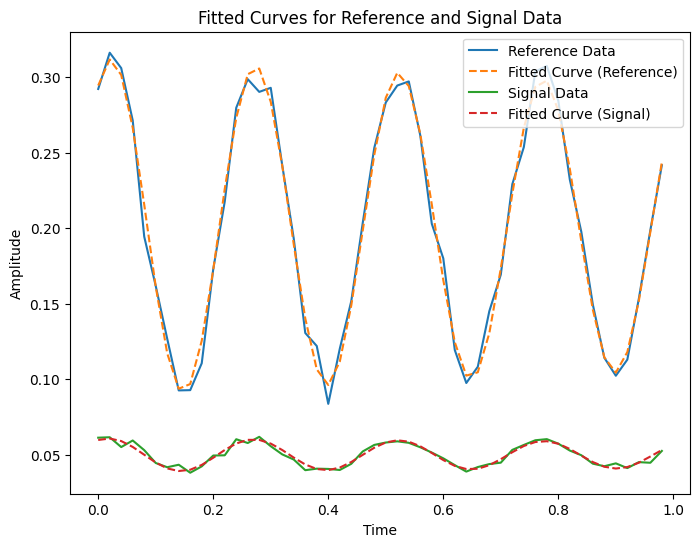

In [127]:
# Fit the signals defined above and calculate the excited state populations.

# Calculate the effective temperature of the transmon in mK

import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt


# Define a damped sinusoidal function with offset
def damped_sinusoidal(t, A, f, phase, offset, decay):
    return A * np.exp(-decay * t) * np.sin(2 * np.pi * f * t + phase) + offset

# Fit the signal to the damped sinusoidal function
params, _ = curve_fit(damped_sinusoidal, time_values, reference)
params_signal, _ = curve_fit(damped_sinusoidal, time_values, signal)

# Extract the fitted parameters where A is the amplitude, f is the frequency
A_ref, f_ref, phase_ref, offset_ref, decay_ref = params
A_signal, f_signal, phase_signal, offset_signal, decay_signal = params_signal

# Calculate the excited state populations for reference and signal
excited_state_population_ref = abs(A_ref) / 2
ground_state_population_ref = 1 - excited_state_population_ref
excited_state_population_signal = abs(A_signal) / 2
ground_state_population_signal = 1 - excited_state_population_signal

# Constants for the Maxwell-Boltzmann distribution
kB = 1.380649 * 10**(-23)  # Boltzmann constant in J/K
h = 6.62607015 * 10**(-34)  # Planck constant in J*s

# Calculate the effective temperature in mK for reference and signal
T_eff_ref = (h * f_ref) / (2 * kB) * 1e3  # Convert to mK
T_eff_signal = (h * f_signal) / (2 * kB) * 1e3  # Convert to mK

# Print the results for reference
print("For Reference Data:")
print(f"Fitted Amplitude (A): {A_ref}")
print(f"Excited State Population: {excited_state_population_ref}")
print(f"Ground State Population: {ground_state_population_ref}")
print(f"Effective Temperature of the Transmon: {T_eff_ref} mK")

# Print the results for signal
print("\nFor Signal Data:")
print(f"Fitted Amplitude (A): {A_signal}")
print(f"Excited State Population: {excited_state_population_signal}")
print(f"Ground State Population: {ground_state_population_signal}")
print(f"Effective Temperature of the Transmon: {T_eff_signal} mK")

# Plot the fitted curves for reference and signal on the same plot
fit_curve_ref = damped_sinusoidal(np.array(time_values), *params)
fit_curve_signal = damped_sinusoidal(np.array(time_values), *params_signal)

plt.figure(figsize=(8, 6))
plt.plot(time_values, reference, label = "Reference Data")
plt.plot(time_values, fit_curve_ref, label = "Fitted Curve (Reference)", linestyle = '--')
plt.plot(time_values, signal, label = "Signal Data")
plt.plot(time_values, fit_curve_signal, label = "Fitted Curve (Signal)", linestyle = '--')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Fitted Curves for Reference and Signal Data")
plt.show()

## Task 3: Implementing the modified protocol

In the paper, the authors describe a modified protocol to measure the excited-state population more efficiently by using only two points on the e-f Rabi oscillation. This protocol requires knowing the frequency and phase of the oscillation, which can be obtained from the data of the previous task.

Please write a Python script defining a `QProgram` that runs the modified protocol.

> Please use comments to explain your code and any assumptions you make.

In [132]:
# Write a QProgram that runs the modified protocol defined in the paper

import inspect
from numpy import pi

# Calculating the duration of the Gaussian signal as a function of the phase and frequency    
duration = phase_signal / (2 * np.pi * frequency_signal)    
    
# Running the modified protocol    
qp = ql.QProgram()
gaussian = Gaussian(amplitude = A_signal, duration = duration, num_sigmas = 4)
sq_pulse = Square(amplitude = 1, duration = 2000)
zero_pulse = Square(amplitude = 0, duration = 2000) #not sure if ql.Square is enough alone so I'm following the example in the documentation
amplitude = qp.variable(float)

with qp.loop(variable = amplitude, values = np.arange(0, 1, 0.01)):
    qp.play(bus = "drive", waveform = gaussian)
    qp.sync()
    qp.play(bus = "readout", waveform = IQPair(I = sq_pulse, Q = zero_pulse))
    qp.acquire(bus = "readout")    
    
    

# Supplementary Material

Please find below some usage examples of the `QProgram` class:

> In `qililab` a `bus` corresponds to a channel used to control one element of the chip (a qubit, a coupler, a resonator, etc.)

1. Loop over the full spectrum of AWG gain [-1.0, 1.0] in 0.1 increments. In each iteration, play a pulse and wait for 100ns before next iteration.

In [5]:
import qililab as ql

qp = ql.QProgram()
gain = qp.variable(float)
with qp.for_loop(variable=gain, start=-1.0, stop=1.0, step=0.1):
    qp.set_gain(bus="drive_q0", gain_path0=gain, gain_path1=gain)
    qp.play(bus="drive_q0", waveform=ql.Square(amplitude=1.0, duration=200))
    qp.wait(bus="drive_q0", time=100)


2. Play a DRAG pulse in the `drive_q0` bus and then play a square pulse in the `readout_q0` bus and start acquisition. `sync()` is used to synchronize between the buses. The sequence is averaged 1000 times.

In [6]:
import qililab as ql

drag_wf = ql.DragPair(amplitude=1.0, duration=80, num_sigmas=4.0, drag_coefficient=1.2)
readout_wf = ql.IQPair(I=ql.Square(amplitude=1.0, duration=200), Q=ql.Square(amplitude=0.0, duration=200))
acq_weights = ql.IQPair(
    I=ql.Gaussian(amplitude=1.0, duration=120, num_sigmas=4), Q=ql.Square(amplitude=0.5, duration=120)
)

qp = ql.QProgram()
with qp.average(shots=1000):
    qp.play(bus="drive_q0", waveform=drag_wf)
    qp.sync()
    qp.play(bus="readout_q0", waveform=readout_wf)
    qp.acquire(bus="readout_q0", weights=acq_weights)
    qp.wait(bus="readout_q0", time=100)